#Predicting PGA Championship Winners

In this notebook, we will attempt to predict the top 10 finishers of the  2015 PGA Championship. Using data from the Golf Channel's website, we will be using a variety of regressors to estimate final round scores, which can later be used to estimate 72-hole totals.

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd
import re
import requests as req
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from bs4 import BeautifulSoup
from IPython.display import HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 25)

In [4]:
HTML('<iframe src=http://www.golfchannel.com/tours/pga-of-america/2015/pga-championship/ width=950 height=500></iframe>')

###Web scraping tables from golfchannel.com using Requests and Beautiful Soup

The Golf Channel website has PGA Championship data going back to 2005, excluding 2010, 2011, and 2013. For each year's webpage, we will first request and soupify the html content and then find and store all of the content from the desired table.

In [5]:
years = ['2005', '2006', '2007', '2008', '2009', '2012', '2014', '2015']

tables = []

for year in years:
    
    # request html content
    html = req.get('http://www.golfchannel.com/tours/pga-of-america/' + year + '/pga-championship/')

    # soupify html content
    soup = BeautifulSoup(html.content, "html.parser")
    
    # find and store all content inside <table> tags
    table = soup.findAll('table')
    tables.append(table)

####Let's take a look at some of the table contents.

In [93]:
tables[0]

[<table class="gc_leaderboard" id="favoritesBoardTable">
 <thead>
 <tr>
 <th></th>
 <th>POS</th>
 <th>MOV</th>
 <th>PLAYER</th>
 <th>OVERALL</th>
 <th>THRU</th>
 <th>RND</th>
 <th>R1</th><th>R2</th><th>R3</th><th>R4</th> <th>TOT</th>
 </tr>
 </thead>
 <tbody class="leaderboard" id="favoritesBoard">
 </tbody>
 </table>, <table class="gc_leaderboard tablesorter" id="fullLeaderboard">
 <thead>
 <tr>
 <th></th>
 <th>POS</th>
 <th>MOV</th>
 <th>PLAYER</th>
 <th>OVERALL</th>
 <th>THRU</th>
 <th>RND</th>
 <th>R1</th><th>R2</th><th>R3</th><th>R4</th> <th>TOT</th>
 </tr>
 </thead>
 <tbody>
 <tr class="playerRow odd">
 <td>
 <div align="center" class="star_is_off">
 <a href="#" rel="11134"></a>
 </div>
 </td>
 <td class="pos">1</td>
 <td>
 <span class="rank"></span> -</td>
 <td class="golfer large">
 <div class="flag16"><img alt="" height="11" src="http://images.thegolfchannel.com/images/element2008/475851.gif" width="21"/></div>
 <p class="golferName">
 <a class="pName" player_id="11134">Mickel

###Dictionaries on dictionaries

Next we will be going through all of the table content and organizing using dictionaries. In this case will actually be populating a main dictionary with many secondary dictionaries as the values.

In [193]:
# empty list to store dictionary of each year's data
dictionaries = []

# iterate through each year's <table> contents
for table in tables:
    
    data = {} # declare empty dictionary
    rows = table[1].findAll('tr') # find and store all data nested in <tr> (row) tags for the rows
    
    # skip the <th> (header) tags
    if len(soup.findAll('th')) > 0: 
        rows = rows[1:]
    
    # iterate through each row
    for row in rows:

        try:
            cells = row.findAll('td') # find and store all data inside <td> (text) tags for the cells
            name = cells[3].get_text().strip() # store player name to use for dictionary keys
            
            # create secondary dictionary and populate with data from cells using BS's get_text() function
            data[name] = {
                'POS' : re.sub("\D", "", cells[1].get_text()), # use regular expressions to strip away any text
                'MOV' : cells[2].get_text().strip(), # use strip() to strip away "\n"
                'OVERALL' : int(cells[4].get_text()),
                'THRU' : cells[5].get_text(),
                'RND' : cells[6].get_text(),
                'R1' : int(cells[7].get_text()), # convert R1, R2, R3, R4, and TOT to numeric types
                'R2' : int(cells[8].get_text()),
                'R3' : int(cells[9].get_text()),
                'R4' : int(cells[10].get_text()),
                'TOT' : cells[11].get_text()
            }
            
        except BaseException:
            pass
    
    # store each year's data
    dictionaries.append(data)

####Let's take a look at one of our dictionaries

In [194]:
dictionaries[0]

{'Ames, Stephen': {'MOV': '-',
  'OVERALL': 11,
  'POS': '72',
  'R1': 67,
  'R2': 72,
  'R3': 74,
  'R4': 78,
  'RND': '+8',
  'THRU': 'F',
  'TOT': '291'},
 'Appleby, Stuart': {'MOV': '-',
  'OVERALL': 1,
  'POS': '15',
  'R1': 67,
  'R2': 70,
  'R3': 69,
  'R4': 75,
  'RND': '+5',
  'THRU': 'F',
  'TOT': '281'},
 'Austin, Woody': {'MOV': '-',
  'OVERALL': 9,
  'POS': '66',
  'R1': 72,
  'R2': 71,
  'R3': 68,
  'R4': 78,
  'RND': '+8',
  'THRU': 'F',
  'TOT': '289'},
 'Bjorn, Thomas': {'MOV': '-',
  'OVERALL': -3,
  'POS': '2',
  'R1': 71,
  'R2': 71,
  'R3': 63,
  'R4': 72,
  'RND': '+2',
  'THRU': 'F',
  'TOT': '277'},
 'Bohn, Jason': {'MOV': '-',
  'OVERALL': 5,
  'POS': '34',
  'R1': 71,
  'R2': 68,
  'R3': 68,
  'R4': 78,
  'RND': '+8',
  'THRU': 'F',
  'TOT': '285'},
 'Calcavecchia, Mark': {'MOV': '-',
  'OVERALL': 10,
  'POS': '70',
  'R1': 70,
  'R2': 69,
  'R3': 77,
  'R4': 74,
  'RND': '+4',
  'THRU': 'F',
  'TOT': '290'},
 'Campbell, Chad': {'MOV': '-',
  'OVERALL': 4,
  '

###Split data into training and testing set

Since we are trying to predict the final round scores of the 2015 tournament, we will use 2015's data in our testing set, and all previous years' data in our training set.

In [195]:
dicts = dictionaries[:6] # append all but 2015's data into new dataframe for training
dftrain = pd.DataFrame()
for d in dicts:
    dftemp = pd.DataFrame(d).T
    dftrain = dftrain.append(dftemp)

dftest = pd.DataFrame(dictionaries[7]).T # 2015's data for testing

###Test data

In [196]:
dftest

,MOV,OVERALL,POS,R1,R2,R3,R4,RND,THRU,TOT
"Aphibarnrat, Kiradech *",6,4,68,72,72,73,75,+3,F,292
"Bae, Sangmoon *",12,2,64,71,72,72,75,+3,F,290
"Bjorn, Thomas",12,-1,48,69,75,69,74,+2,F,287
"Bohn, Jason",13,-3,37,74,71,66,74,+2,F,285
"Bradley, Keegan *",3,1,61,76,70,72,71,-1,F,289
"Casey, Paul *",13,-4,30,70,70,70,74,+2,F,284
"Chappell, Kevin",28,-2,43,73,68,78,67,-5,F,286
"Coetzee, George *",6,-12,7,74,65,70,67,-5,F,276
"Day, Jason *",-,-20,1,68,67,66,67,-5,F,268
"Donald, Luke",13,-2,43,72,70,70,74,+2,F,286


###Training data

In [197]:
dftrain

,MOV,OVERALL,POS,R1,R2,R3,R4,RND,THRU,TOT
"Ames, Stephen",-,11,72,67,72,74,78,+8,F,291
"Appleby, Stuart",-,1,15,67,70,69,75,+5,F,281
"Austin, Woody",-,9,66,72,71,68,78,+8,F,289
"Bjorn, Thomas",-,-3,2,71,71,63,72,+2,F,277
"Bohn, Jason",-,5,34,71,68,68,78,+8,F,285
"Calcavecchia, Mark",-,10,70,70,69,77,74,+4,F,290
"Campbell, Chad",-,4,28,71,71,70,72,+2,F,284
"Campbell, Michael",-,-1,6,73,68,69,69,-1,F,279
"Casey, Paul",-,8,59,70,74,72,72,+2,F,288
"Choi, K.J.",-,6,40,71,70,73,72,+2,F,286


###Clean up the datasets

We want to drop any features that won't be useful in our predictions.

In [198]:
dftrain.columns = ['MOV', 'OVERALL', 'POS', 'R1', 'R2', 'R3', 'R4', 'RND', 'THRU', 'TOT']

#dftrain['MOV'] = dftrain['MOV'].replace('-', 0)
dftrain = dftrain.drop(dftrain.columns[[0, 1, 2, 7, 8, 9]], 1)

#dftrain = dftrain.convert_objects(convert_numeric=True)

In [199]:
dftest.columns = ['MOV', 'OVERALL', 'POS', 'R1', 'R2', 'R3', 'R4', 'RND', 'THRU', 'TOT']

#dftest['MOV'] = dftest['MOV'].replace('-', 0)
dftest = dftest.drop(dftest.columns[[0, 1, 2, 7, 8, 9]], 1)

#dftrain = dftrain.convert_objects(convert_numeric=True)

In [170]:
dftest

,R1,R2,R3,R4
"Aphibarnrat, Kiradech *",72,72,73,75
"Bae, Sangmoon *",71,72,72,75
"Bjorn, Thomas",69,75,69,74
"Bohn, Jason",74,71,66,74
"Bradley, Keegan *",76,70,72,71
"Casey, Paul *",70,70,70,74
"Chappell, Kevin",73,68,78,67
"Coetzee, George *",74,65,70,67
"Day, Jason *",68,67,66,67
"Donald, Luke",72,70,70,74


In [171]:
dftrain

,R1,R2,R3,R4
"Ames, Stephen",67,72,74,78
"Appleby, Stuart",67,70,69,75
"Austin, Woody",72,71,68,78
"Bjorn, Thomas",71,71,63,72
"Bohn, Jason",71,68,68,78
"Calcavecchia, Mark",70,69,77,74
"Campbell, Chad",71,71,70,72
"Campbell, Michael",73,68,69,69
"Casey, Paul",70,74,72,72
"Choi, K.J.",71,70,73,72


In [172]:
y = dftrain[[3]]
x = dftrain[[0, 1, 2]]

###Predictions
Now we will make our predictions. First we will try out a linear regression, then we will use a more complicated method.

In [174]:
#dftest.sort('TOT').head(10)

####Linear regression

In [175]:
lm = LinearRegression()
lm.fit(x, y)
lmpred = lm.predict(dftest[[0, 1, 2]])

print(lm.intercept_)
print(lm.coef_)

[ 57.87174448]
[[ 0.10650248 -0.04103787  0.14440993]]


####Random forest regressor tuned with randomized search

In [176]:
rfr = RandomForestRegressor(n_estimators=100, random_state=91)

In [177]:
n_iter = 10

feat_range = sp_randint(1, x.shape[1])
depth_range = sp_randint(1, 21)
boot_range = [True, False]

params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

In [178]:
rand = RandomizedSearchCV(rfr, params, cv=5, n_jobs=-1, n_iter=n_iter, scoring='mean_squared_error', random_state=91)

random_search = rand.fit(x, y)

rfr = rand.best_estimator_

In [179]:
rfpred = rfr.predict(dftest[[0, 1, 2]])

####Add predictions to dataframe

In [180]:
dftest['lmpredR4'] = lmpred
dftest['rfpredR4'] = rfpred

In [181]:
dftest['TOT'] = dftest[[0, 1, 2, 3]].sum(axis=1)
dftest['lmpredTOT'] = dftest[[0, 1, 2, 4]].sum(axis=1)
dftest['rfpredTOT'] = dftest[[0, 1, 2, 5]].sum(axis=1)

###Results

In [182]:
dftest.sort('lmpredTOT').head(10)

,R1,R2,R3,R4,lmpredR4,rfpredR4,TOT,lmpredTOT,rfpredTOT
"Day, Jason *",68,67,66,67,71.895431,72.421341,268,272.895431,273.421341
"Spieth, Jordan",71,67,65,68,72.070528,72.373073,271,275.070528,275.373073
"Grace, Branden",71,69,64,69,71.844043,72.417309,273,275.844043,276.417309
"Rose, Justin *",69,67,68,70,72.290753,72.691493,274,276.290753,276.691493
"Kaymer, Martin *",70,70,65,73,71.840912,72.329140,278,276.840912,277.329140
"Finau, Tony",71,66,69,71,72.689206,72.704661,277,278.689206,278.704661
"Johnson, Dustin *",66,73,68,69,71.725018,73.239304,276,278.725018,280.239304
"Jones, Matt",68,65,73,75,72.988376,73.071927,281,278.988376,279.071927
"Lahiri, Anirban",70,67,70,68,72.686075,72.816479,275,279.686075,279.816479
"Kuchar, Matt *",68,72,68,68,71.979061,72.681566,276,279.979061,280.681566


In [183]:
lmRSq = (dftest[['TOT', 'lmpredTOT']].corr())**2
lmRSq

,TOT,lmpredTOT
TOT,1.000000,0.771446
lmpredTOT,0.771446,1.000000


In [184]:
mean_squared_error(dftest['TOT'], dftest['lmpredTOT'])

10.616211212266956

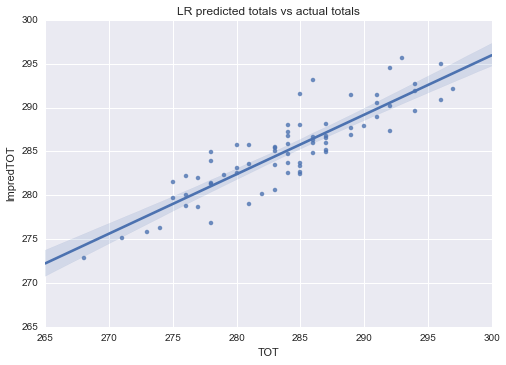

In [185]:
sns.regplot('TOT', 'lmpredTOT', dftest)
plt.title('LR predicted totals vs actual totals')

In [186]:
dftest.sort('rfpredTOT').head(10)

,R1,R2,R3,R4,lmpredR4,rfpredR4,TOT,lmpredTOT,rfpredTOT
"Day, Jason *",68,67,66,67,71.895431,72.421341,268,272.895431,273.421341
"Spieth, Jordan",71,67,65,68,72.070528,72.373073,271,275.070528,275.373073
"Grace, Branden",71,69,64,69,71.844043,72.417309,273,275.844043,276.417309
"Rose, Justin *",69,67,68,70,72.290753,72.691493,274,276.290753,276.691493
"Kaymer, Martin *",70,70,65,73,71.840912,72.329140,278,276.840912,277.329140
"Finau, Tony",71,66,69,71,72.689206,72.704661,277,278.689206,278.704661
"Jones, Matt",68,65,73,75,72.988376,73.071927,281,278.988376,279.071927
"Lahiri, Anirban",70,67,70,68,72.686075,72.816479,275,279.686075,279.816479
"Johnson, Dustin *",66,73,68,69,71.725018,73.239304,276,278.725018,280.239304
"Kuchar, Matt *",68,72,68,68,71.979061,72.681566,276,279.979061,280.681566


In [187]:
rfRSq = (dftest[['TOT', 'rfpredTOT']].corr())**2
rfRSq

,TOT,rfpredTOT
TOT,1.00000,0.77471
rfpredTOT,0.77471,1.00000


In [188]:
mean_squared_error(dftest['TOT'], dftest['rfpredTOT'])

11.050526347735408

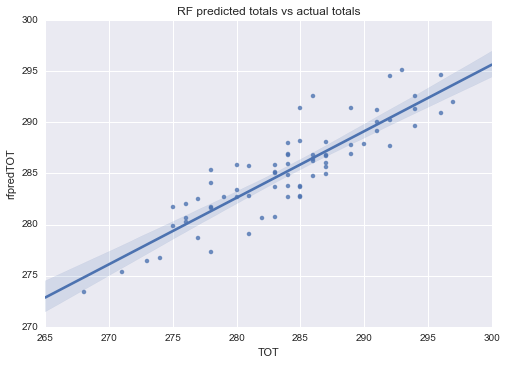

In [189]:
sns.regplot('TOT', 'rfpredTOT', dftest)
plt.title('RF predicted totals vs actual totals')

###Conclusion
Linear regression and random forest regression performed about the same with $R^2$ values of around .77, and both methods correctly predict the top 4 finishers. In this case, the added complexity of random forest didn't significantly improve the performance of our prediciton.